<a href="https://colab.research.google.com/github/srilamaiti/ml_works/blob/main/lag_llama_ts_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting

![lag-llama-architecture](https://raw.githubusercontent.com/time-series-foundation-models/lag-llama/main/images/lagllama.webp)

Lag-Llama is the <b>first open-source foundation model for time series forecasting</b>!

[[Tweet Thread](https://twitter.com/arjunashok37/status/1755261111233114165)] [[Model Weights](https://huggingface.co/time-series-foundation-models/Lag-Llama)] [[Colab Demo on Zero-Shot Forecasting](https://colab.research.google.com/drive/1XxrLW9VGPlZDw3efTvUi0hQimgJOwQG6?usp=sharing)] [[GitHub](https://github.com/time-series-foundation-models/lag-llama)] [[Paper](https://arxiv.org/abs/2310.08278)]

💫 This Colab Demo shows you how to use the pretrained Lag-Llama model to get zero-shot predictions on time series, with the ability to load time series of different formats.


# Prepare the repository

We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.



In [ ]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [ ]:
cd /content/lag-llama

/content/lag-llama


In [ ]:
!pip install -U -r requirements.txt  # this could take some time # ignore the errors displayed by colab

  Using cached numpy-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


**Restart your runtime now, and then continue**

In [ ]:
cd /content/lag-llama

/content/lag-llama


We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

/content/lag-llama/lag-llama.ckpt


We import the required packages and the lag llama estimator object which we can use to make predictions.

In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import gluonts.torch.distributions.studentT as studentT

# Add StudentTOutput to the safe globals list before loading
torch.serialization.add_safe_globals([studentT.StudentTOutput])
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

In [ ]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

# Lag-Llama prediction function

We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (`num_samples`, `prediction_length`), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.


In [ ]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    #ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# Loading datasets of different types

We expand upon how one can support loading data stored in different formats. This part of the demo uses the tutorial by the authors of GluonTS at https://ts.gluon.ai/stable/tutorials/data_manipulation/pandasdataframes.html. We thank the authors of GluonTS for putting together such a detailed tutorial.

## Important Points to Note

1. The prediction function provided in this notebook performs a prediction autoregressively for the last `prediction_length` steps in the dataset passed.

For the time being, if you would like to perform prediction, please include in the CSV/dataframe the timestamps you want to perform prediction for (with a dummy value), and set the prediction length to the required horizon.

2. Please keep in mind that Lag-Llama needs a minimum context of `32` timestamps before the prediction timestamp starts. Beyond the `32` timestamps, Lag-Llama can use a context of upto `1092` more timestamps in history for the lags - this part is optional but you will find that as you give more context upto `(32+) 1092` timestamps, Lag-Llama's performance will improve.

The context length passed below should not be changed and kept at 32 nevertheless. Lag-Llama will automatically use context beyond 32 for the lags, if available.


## 2. Loading data with missing values

In case the timestamp column is not evenly spaced and monotonically increasing we get an error when using PandasDataset. Here we show how to fill in the gaps that are missing.

To demonstrate this, let’s first remove some random rows from the long dataset.

We plot the forecasts of our model on this dataset.

In [ ]:
!ls -ltr

total 28908
-rw-r--r-- 1 root root        5 Feb 11 13:58 VERSION
-rw-r--r-- 1 root root     7515 Feb 11 13:58 README.md
-rw-r--r-- 1 root root       41 Feb 11 13:58 MANIFEST.in
-rw-r--r-- 1 root root    11357 Feb 11 13:58 LICENSE
drwxr-xr-x 2 root root     4096 Feb 11 13:58 configs
drwxr-xr-x 2 root root     4096 Feb 11 13:58 images
drwxr-xr-x 3 root root     4096 Feb 11 13:58 gluon_utils
drwxr-xr-x 3 root root     4096 Feb 11 13:58 data
-rw-r--r-- 1 root root      100 Feb 11 13:58 requirements.txt
-rw-r--r-- 1 root root      861 Feb 11 13:58 pyproject.toml
drwxr-xr-x 4 root root     4096 Feb 11 13:58 lag_llama
-rw-r--r-- 1 root root    33318 Feb 11 13:58 run.py
drwxr-xr-x 2 root root     4096 Feb 11 13:58 utils
drwxr-xr-x 2 root root     4096 Feb 11 13:58 scripts
-rw-r--r-- 1 root root     7326 Feb 11 13:59 top_10_prod_sales.csv
-rw-r--r-- 1 root root 29488819 Feb 11 13:59 lag-llama.ckpt


In [ ]:
df_sales = pd.read_csv("top_10_prod_sales.csv")
df_sales.shape

(242, 3)

In [ ]:
df_sales.head()

,PROD_ID,FISC_YR_MTH,TOTAL_SALES_QTY
0,50626-PWR,2023 APRIL,3333800
1,64575FC-PWR,2023 APRIL,3048000
2,55310-PWR,2023 APRIL,2757600
3,DFM12720,2023 APRIL,2688300
4,DCN890075,2023 APRIL,1675000


In [ ]:
df_sales.columns = ['item_id', 'sales_month', 'target']
df_sales.head()

,item_id,sales_month,target
0,50626-PWR,2023 APRIL,3333800
1,64575FC-PWR,2023 APRIL,3048000
2,55310-PWR,2023 APRIL,2757600
3,DFM12720,2023 APRIL,2688300
4,DCN890075,2023 APRIL,1675000


In [ ]:
df_sales['date'] = pd.to_datetime(df_sales['sales_month'], format='%Y %B')
df_sales = df_sales.drop(columns=['sales_month'])
#df_sales['formatted_date'] = df_sales['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
#df_sales = df_sales.drop(columns=['date'])
#df_sales.sort_values(by='formatted_date', inplace=True)
df_sales.sort_values(by='date', inplace=True)
df_sales.head()

,item_id,target,date
45,64575FC-PWR,2876800,2023-01-01
44,50630-PWR,122300,2023-01-01
41,DFM12720,1755600,2023-01-01
46,55310-PWR,2011200,2023-01-01
47,DFM2ELD420,1313000,2023-01-01


In [ ]:
df_sales['item_id'].unique()

array(['64575FC-PWR', '50630-PWR', 'DFM12720', '55310-PWR', 'DFM2ELD420',
       '02814-PWR', 'DFM12722', '50626-PWR', '64580FC-PWR', 'DCN890075'],
      dtype=object)

In [ ]:
df_sales.groupby('item_id').count()

,target,date
item_id,,
02814-PWR,25,25
50626-PWR,25,25
50630-PWR,25,25
55310-PWR,25,25
64575FC-PWR,24,24
64580FC-PWR,24,24
DCN890075,25,25
DFM12720,25,25
DFM12722,25,25


In [ ]:
df_sales.head()

,item_id,target,date
45,64575FC-PWR,2876800,2023-01-01
44,50630-PWR,122300,2023-01-01
41,DFM12720,1755600,2023-01-01
46,55310-PWR,2011200,2023-01-01
47,DFM2ELD420,1313000,2023-01-01


In [ ]:
date_range = pd.date_range(start="2023-01-01", end="2025-02-01", freq="MS")

# Create a DataFrame
df_dates = pd.DataFrame({"date": date_range})

print(df_dates)

         date
0  2023-01-01
1  2023-02-01
2  2023-03-01
3  2023-04-01
4  2023-05-01
5  2023-06-01
6  2023-07-01
7  2023-08-01
8  2023-09-01
9  2023-10-01
10 2023-11-01
11 2023-12-01
12 2024-01-01
13 2024-02-01
14 2024-03-01
15 2024-04-01
16 2024-05-01
17 2024-06-01
18 2024-07-01
19 2024-08-01
20 2024-09-01
21 2024-10-01
22 2024-11-01
23 2024-12-01
24 2025-01-01
25 2025-02-01


In [ ]:
df_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    26 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 340.0 bytes


In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 45 to 241
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   item_id  242 non-null    object        
 1   target   242 non-null    int64         
 2   date     242 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 7.6+ KB


In [ ]:
df_sales.to_csv('top_10_prod_sales_1.csv', index=False)

In [ ]:
df_all_comb = pd.merge(df_sales['item_id'].drop_duplicates(), df_dates, how='cross')
df_sales_combined = pd.merge(df_all_comb, df_sales, how='left', on = ['date', 'item_id'])
df_sales_combined['target'] = df_sales_combined['target'].fillna(0)
df_sales_combined.head()

,item_id,date,target
0,64575FC-PWR,2023-01-01,2876800.0
1,64575FC-PWR,2023-02-01,3209600.0
2,64575FC-PWR,2023-03-01,3170400.0
3,64575FC-PWR,2023-04-01,3048000.0
4,64575FC-PWR,2023-05-01,2124000.0


In [ ]:
df_all_comb.groupby('item_id').count()

,date
item_id,
02814-PWR,26
50626-PWR,26
50630-PWR,26
55310-PWR,26
64575FC-PWR,26
64580FC-PWR,26
DCN890075,26
DFM12720,26
DFM12722,26


In [ ]:
df_sales_combined.groupby('item_id').count()

,date,target
item_id,,
02814-PWR,26,26
50626-PWR,26,26
50630-PWR,26,26
55310-PWR,26,26
64575FC-PWR,26,26
64580FC-PWR,26,26
DCN890075,26,26
DFM12720,26,26
DFM12722,26,26


In [ ]:
df_sales_combined.head()

,item_id,date,target
0,64575FC-PWR,2023-01-01,2876800.0
1,64575FC-PWR,2023-02-01,3209600.0
2,64575FC-PWR,2023-03-01,3170400.0
3,64575FC-PWR,2023-04-01,3048000.0
4,64575FC-PWR,2023-05-01,2124000.0


In [ ]:
df_sales_combined['date'] = pd.to_datetime(df_sales_combined['date'])

In [ ]:
df_sales_combined.head()

,item_id,date,target
0,64575FC-PWR,2023-01-01,2876800.0
1,64575FC-PWR,2023-02-01,3209600.0
2,64575FC-PWR,2023-03-01,3170400.0
3,64575FC-PWR,2023-04-01,3048000.0
4,64575FC-PWR,2023-05-01,2124000.0


In [ ]:
#df_sales.set_index('formatted_date', inplace=True)
df_sales_combined.set_index('date', inplace=True)
df_sales_combined.head()

,item_id,target
date,,
2023-01-01,64575FC-PWR,2876800.0
2023-02-01,64575FC-PWR,3209600.0
2023-03-01,64575FC-PWR,3170400.0
2023-04-01,64575FC-PWR,3048000.0
2023-05-01,64575FC-PWR,2124000.0


In [ ]:
df_sales_combined.groupby('item_id').count()

,target
item_id,
02814-PWR,26
50626-PWR,26
50630-PWR,26
55310-PWR,26
64575FC-PWR,26
64580FC-PWR,26
DCN890075,26
DFM12720,26
DFM12722,26


In [ ]:
df_sales_combined = df_sales_combined[['target', 'item_id']]
df_sales_combined.head()

,target,item_id
date,,
2023-01-01,2876800.0,64575FC-PWR
2023-02-01,3209600.0,64575FC-PWR
2023-03-01,3170400.0,64575FC-PWR
2023-04-01,3048000.0,64575FC-PWR
2023-05-01,2124000.0,64575FC-PWR


<Axes: xlabel='date'>

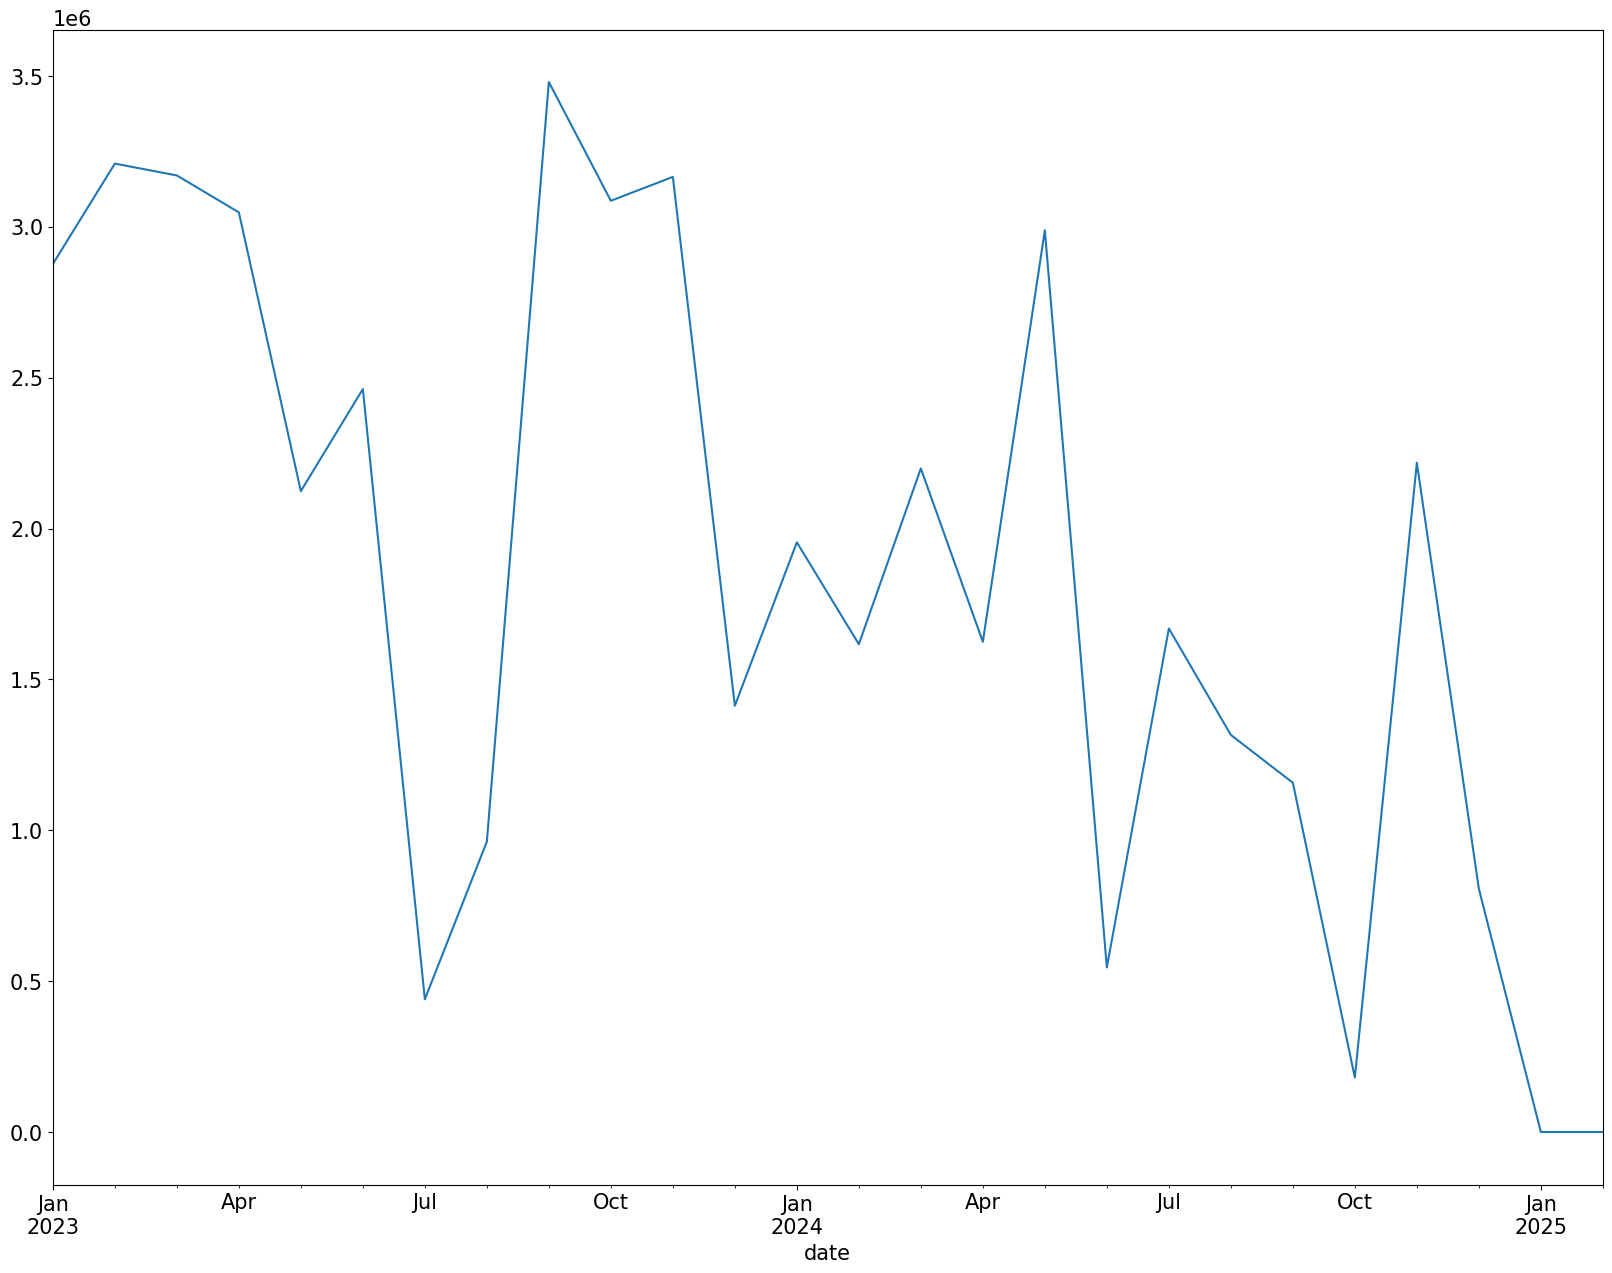

In [ ]:
plt.figure(figsize=(20, 15))
df_sales_combined[df_sales_combined.item_id == '64575FC-PWR']['target'].plot()

<Axes: xlabel='date'>

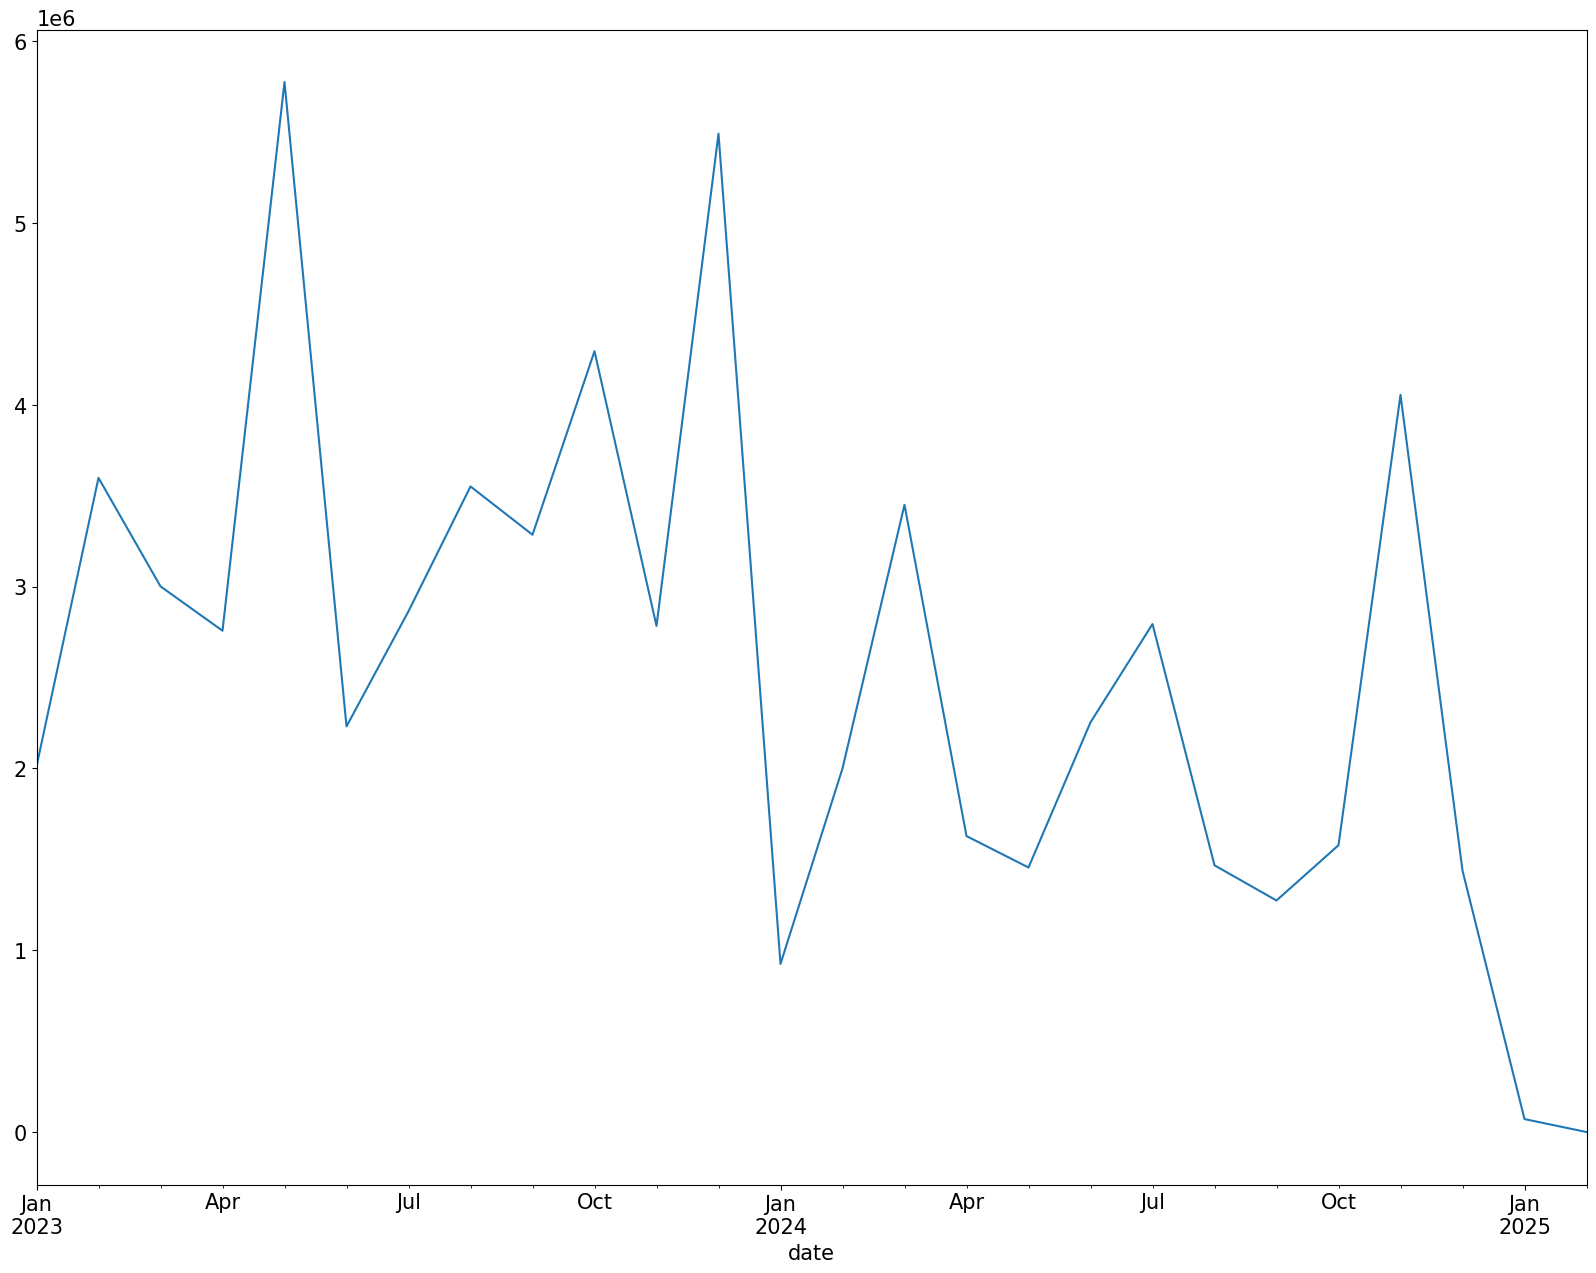

In [ ]:
plt.figure(figsize=(20, 15))
df_sales_combined[df_sales_combined.item_id == '55310-PWR']['target'].plot()

In [ ]:
# Set numerical columns as float32
for col in df_sales_combined.columns:
    # Check if column is not of string type
    if df_sales_combined[col].dtype != 'object' and pd.api.types.is_string_dtype(df_sales_combined[col]) == False:
        df_sales_combined[col] = df_sales_combined[col].astype('float32')

# Create the Pandas
sales_dataset = PandasDataset.from_long_dataframe(df_sales_combined, target="target", item_id="item_id")

backtest_dataset = sales_dataset
prediction_length = 3  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 21 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

In [ ]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

In [ ]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id='02814-PWR', samples=array([[ 2363727.   ,  2425867.2  ,  2208141.8  ],
        [ 2149386.2  ,  2091722.2  ,   818869.75 ],
        [ 1904434.8  ,  2029027.   ,  1861948.   ],
        [ 1699940.   ,  1888629.5  ,  1479380.5  ],
        [ 1936554.9  ,  2065611.6  ,  1668827.5  ],
        [ 2090319.2  ,  2255802.8  ,  2486765.8  ],
        [ 2339431.5  ,  2683598.5  ,  2429400.5  ],
        [ 1523159.1  ,  1789844.2  ,  1844694.6  ],
        [ 2005841.2  ,  1938733.2  ,  1943798.4  ],
        [ 1648744.8  ,  1215492.5  ,   720252.4  ],
        [ 1845202.9  ,  1744166.2  ,  1618110.1  ],
        [ 2391086.8  ,  2417478.8  ,  2452985.2  ],
        [ 2132318.5  ,  2253007.8  ,  2121442.8  ],
        [ 2428452.2  ,  2352649.5  ,  2034287.8  ],
        [ 1937753.2  ,  2413244.8  ,  2160000.   ],
        [ 1977980.1  ,  2241275.5  ,  2229348.5  ],
        [ 1611054.2  ,  1749067.   ,  2002522.5  ],
        [ 2309766.2  ,  2037627.2  ,  

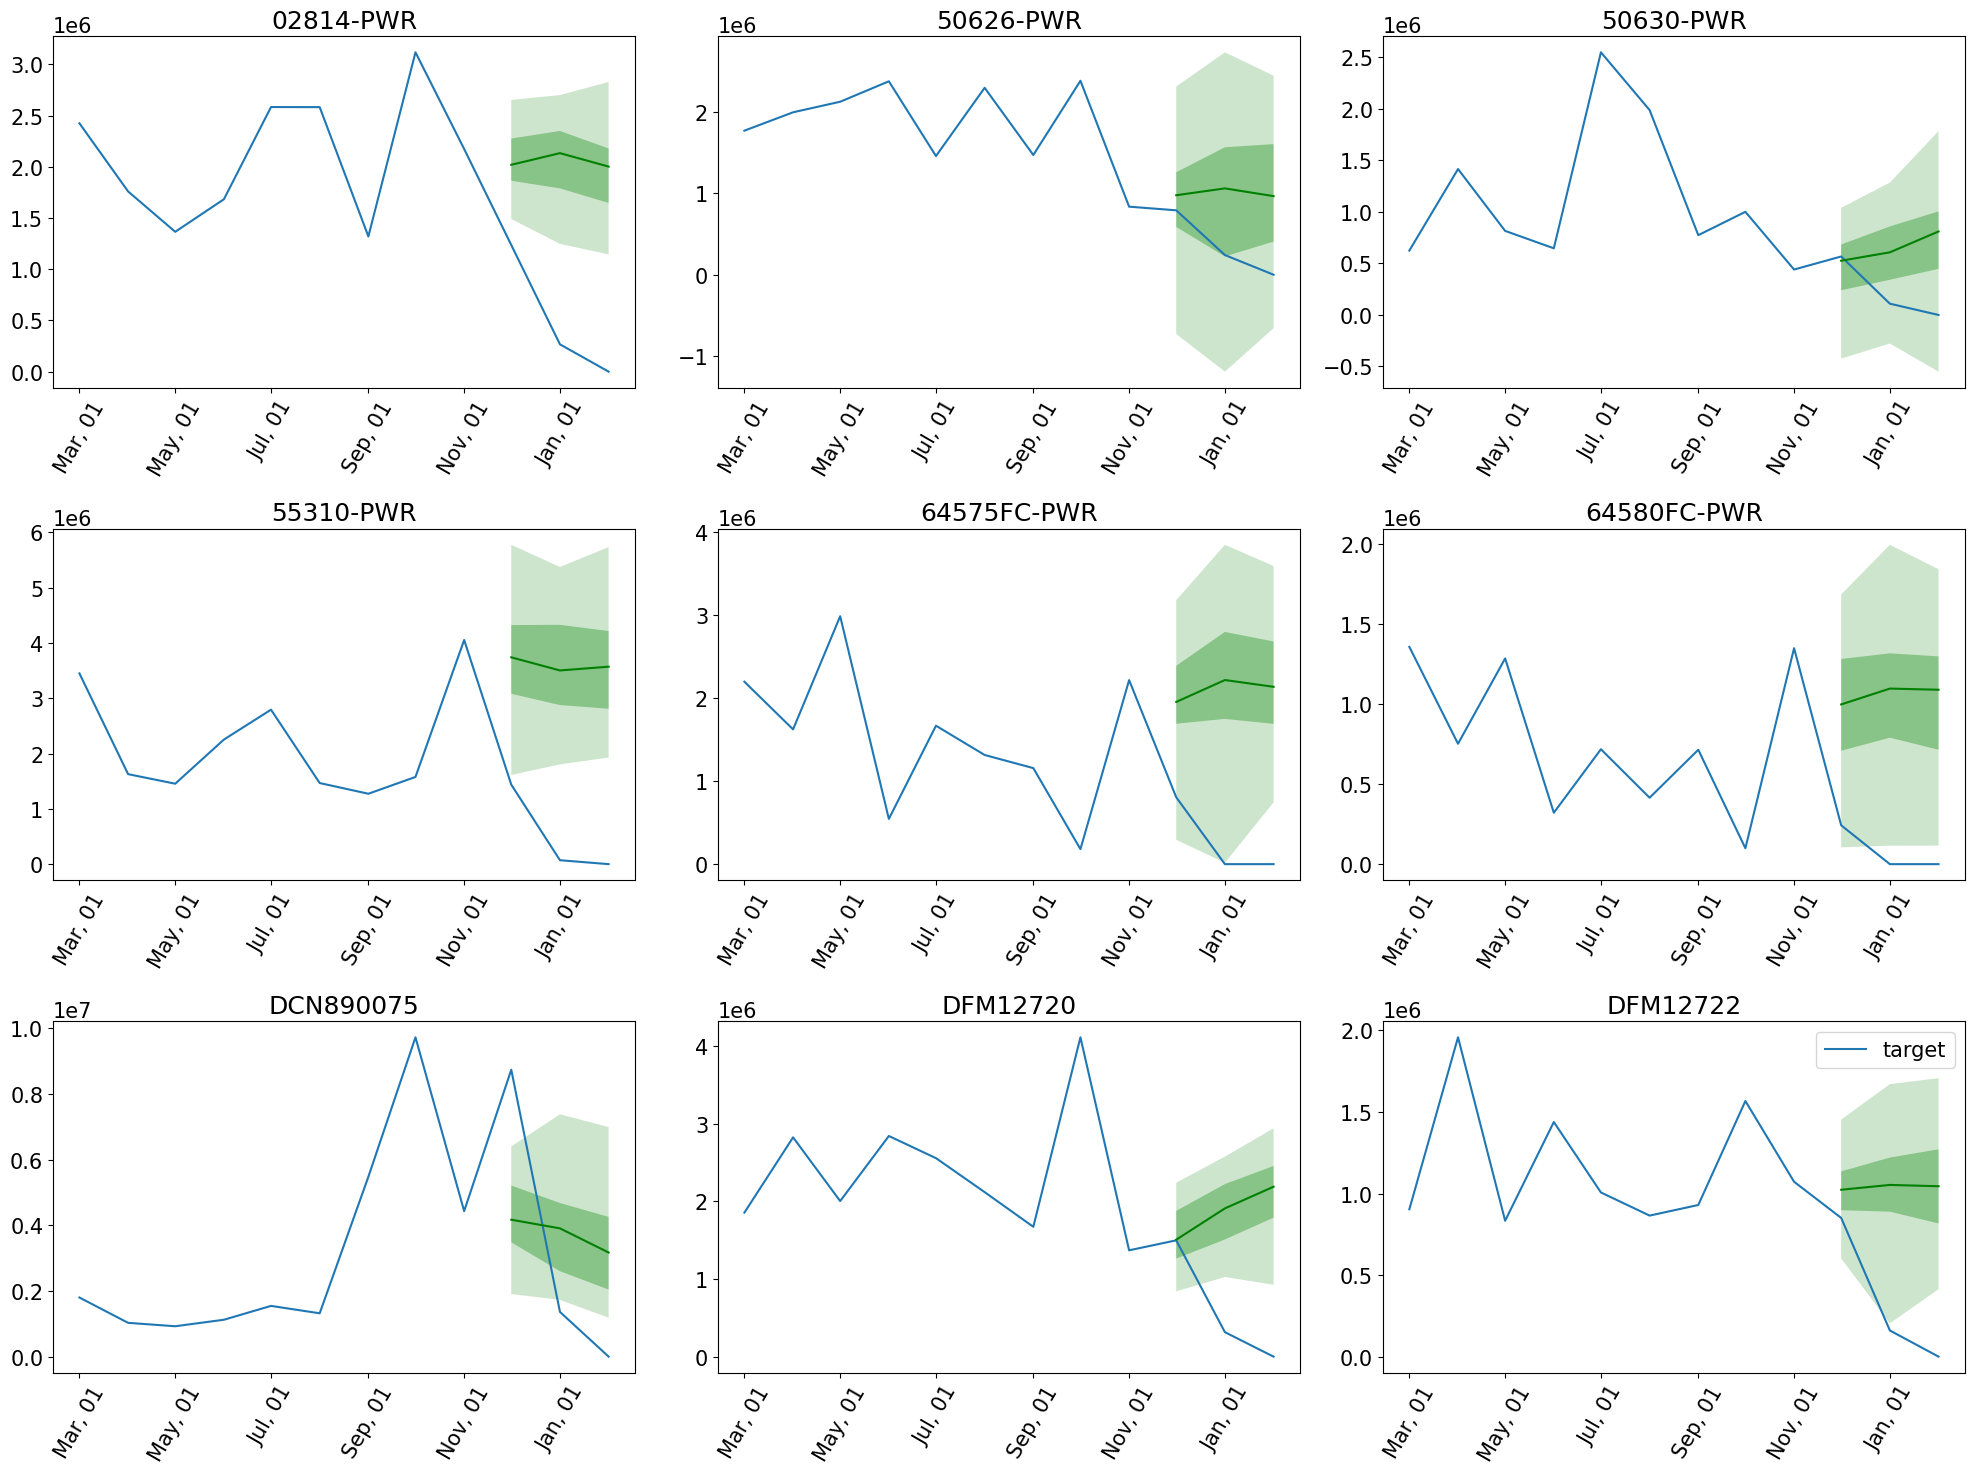

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [ ]:
forecasts_list = list(forecasts)
tss_list = list(tss)

evaluator = Evaluator()
agg_metrics_ctx_len_64_rope_scaled, ts_metrics_ctx_len_64_rope_scaled = evaluator(iter(tss_list), iter(forecasts_list))
print("CRPS:", agg_metrics_ctx_len_64_rope_scaled['mean_wQuantileLoss'])

Running evaluation: 10it [00:00, 391.27it/s]


CRPS: 1.9259408745880329


/usr/local/lib/python3.11/dist-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


We get a CRPS of **0.0774**.
